In [120]:
from abc import ABC, abstractmethod
from typing import Optional, Tuple, List
from sklearn.metrics import classification_report
import numpy as np

In [121]:
class Node(ABC):
    '''Clase base abstracta para nodos en una red neuronal.'''

    def __init__(self, has_weights: bool = False):
        self.output: np.ndarray | float = None # type: ignore
        self.grad: np.ndarray | Tuple[np.ndarray, ...] | None = None
        self.has_weights = has_weights

    def __call__(self, *x) -> np.ndarray:
        return self.forward(*x)

    @abstractmethod
    def forward(self, x) -> np.ndarray:
        '''Ejecuta la operación de propagación hacia adelante para este nodo..'''

    @abstractmethod
    def backward(self, incoming_grad) -> np.ndarray | None:
        '''Calcula el gradiente durante la retropropagación para este nodo.'''

In [122]:
class Linear(Node):

    def __init__(self, input_size: int, output_size: int):
        super().__init__(has_weights = True)
        self.w = np.random.rand(output_size, input_size) # filas neuronas, columnas pesos
        self.b = np.random.rand(output_size)[:, np.newaxis] # [:, np.newaxis] tranforma en un vector columna
        self.h: Optional[np.ndarray] = None # salida de la capa anterior
    
    def forward(self, x) -> np.ndarray:
        self.h = x
        self.output = np.dot(self.w, self.h) + self.b
        return self.output
    
    def backward(self, incoming_grad) -> None:
        grad_w = np.zeros_like(self.w)
        grad_b = np.zeros_like(self.b)
        for i in range(incoming_grad.shape[-1]):
            grad_w += np.outer(incoming_grad[:,i], self.h[:, i])
            grad_b += incoming_grad[:,i][:, np.newaxis]

        self.grad = grad_w, grad_b

In [123]:
class ReLU(Node):
    
    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None # preactivacion

    def forward(self, x):
        self.a = x
        self.output = np.maximum(0, self.a) # funcion de maximo aplicado a cada entrada
        return self.output
    
    def backward(self, incoming_grad):
        self.grad = incoming_grad * (self.a > 0) # (self.a > 0) es matriz de booleanos (una mascara)
        return self.grad

In [124]:
class Tanh(Node):

    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None

    def forward(self, x):
        self.a = np.clip(x, -18.5, 18.5) # evitando errores numericos pues np.tanh(19) = 1 !
        self.output = np.tanh(self.a)
        return self.output 

    def backward(self, incoming_grad):
        self.grad = incoming_grad * (1 - self.output ** 2)
        return self.grad

In [125]:
def kronecker_delta(x,y):
    if x == y:
        return 1
    else:
        return 0

class Softmax(Node):

    def __init__(self):
        super().__init__()
        self.a: Optional[np.ndarray] = None   

    def forward(self, x) -> np.ndarray:
        self.a = np.clip(x, -709, 709) # evitando errores numericos pues np.exp(-746) = 0.0 y np.exp(710) = inf
        exp_a = np.exp(self.a)
        sum_column = np.sum(exp_a, axis=0) # vector con las sumas aculadas de cada columna
        self.output = exp_a / sum_column # division de cada elemento por su suma de columna correspondiente
        return self.output
    
    def backward(self, incoming_grad) -> np.ndarray:
        # Calculamos el Jacobiano de la Softmax y se lo aplicamos al gradiente del padre

        self.grad = np.zeros_like(self.output.T) # Gradiente con dimensiones del output

        # Iteramos sobre columnas, es decir por cada dato (no por cada variable)
        for column_index in range(self.output.shape[1]):

            column = self.output.T[column_index] # Un sólo dato con la softmax
            x_size = len(column)

            # Construimos el jacobiano
            J =  np.zeros((x_size, x_size))
            for i in range(x_size):
                for j in range(x_size):
                    J[i][j] = column[i] * ( kronecker_delta(i,j) - column[j])

            # Aplicamos el producto a la columna correspondiente, por eso transponemos
            self.grad[column_index] = np.dot(J, incoming_grad.T[column_index])
        
        self.grad = self.grad.T # Se usa la transpuesta para mantener las dimensiones correctas

        return self.grad



In [126]:
class CrossEntropy(Node):
    
    def __init__(self,):
        super().__init__()
    
    def forward(self, y_pred, y_real) -> np.ndarray:
        epsilon = 1e-9
        entry_contribution = y_real * np.log(y_pred + epsilon)
        self.output = - np.sum(entry_contribution, axis=0)
        return self.output 

    def backward(self, y_pred, y_real) -> np.ndarray:
        return - (y_real / (y_pred + 1e-9))

In [127]:
class Sequential(Node):
    
    def __init__(self, *layers: Tuple[Node, ...], error_node=None):
        super().__init__()
        self.layers: Tuple[Node, ...] = layers
        self.error_node: Node = error_node
        self.weighted_layers: List[Node] = [] # Nodos/capas con pesos

        for layer in layers:
            if layer.has_weights:
                self.weighted_layers.append(layer)
        
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        x = x.T
        if x.ndim == 1: # si solo es un dato se transforma a vector columna
            x = x[:, np.newaxis]
        actual_val = x
        # print(actual_val)
        for layer in self.layers:
            actual_val = layer(actual_val)
            # print(type(layer))
            # print(actual_val)
        self.output = actual_val
        return self.output.T
    
    def backward(self, labeles_of_data) -> None:

        dL_df = self.error_node.backward(self.output, labeles_of_data.T)

        i = len(self.layers) - 1
        d_kp1 = self.layers[i].backward(dL_df)
        self.layers[i - 1].backward(d_kp1)
        w_kp1 = self.layers[i - 1].w
        i -= 2
        
        # print(d_kp1)
        for weighted_layer in reversed(self.weighted_layers[:-1]):
            # print(type(weighted_layer))
            d_k = self.layers[i].backward(np.dot(w_kp1.T, d_kp1))
            # print(d_k)
            weighted_layer.backward(d_k)
            d_kp1 = d_k
            w_kp1 = self.layers[i - 1].w # Uriel: creo que falta esto
            i -= 2


In [128]:
def make_classification(r0=1,r1=3,k=1000):
    """
    Creacion de los datos
    """
    X1 = [np.array([r0*np.cos(t),r0*np.sin(t)]) for t in range(0,k)]
    X2 = [np.array([r1*np.cos(t),r1*np.sin(t)]) for t in range(0,k)]
    X = np.concatenate((X1,X2))
    n,d = X.shape
    Y = np.zeros(2*k)
    Y[k:] += 1
    noise = np.array([np.random.normal(0,1,2) for i in range(n)])
    X += 0.5*noise
    return X,Y

In [129]:
def create_mini_batches(X, Y, batch_size):
    mini_batches = []
    indices = np.arange(X.shape[0]) # arreglo con los indices de cada dato 
    np.random.shuffle(indices) # los mezclamos

    # Dividimos en mini-batches
    for i in range(0, X.shape[0], batch_size):
        batch_indices = indices[i:i + batch_size]
        X_batch = X[batch_indices]
        Y_batch = Y[batch_indices]
        mini_batches.append((X_batch, Y_batch))

    return mini_batches

In [130]:
def create_plot_of_points(x: np.ndarray, y: np.ndarray, title: str) -> None:
    import matplotlib.pyplot as plt

    plt.scatter(x[:,0], x[:,1], s=5, c=np.where(y == 0, 'blue', 'red'))

    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='Class 0')
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Class 1')

    plt.legend(handles=[blue_patch, red_patch], title='Classes', fontsize='small')

    plt.title(title)
    # plt.savefig(f'{title}.png')
    # print(f"file saved as: '{title}.png'")

In [137]:
x, y = make_classification()
print()
# create_plot_of_points(x, y, 'real_classification')
print()

pre-training results:
              precision    recall  f1-score   support

     Class 0       0.32      0.19      0.23      1000
     Class 1       0.42      0.60      0.50      1000

    accuracy                           0.39      2000
   macro avg       0.37      0.39      0.37      2000
weighted avg       0.37      0.39      0.37      2000






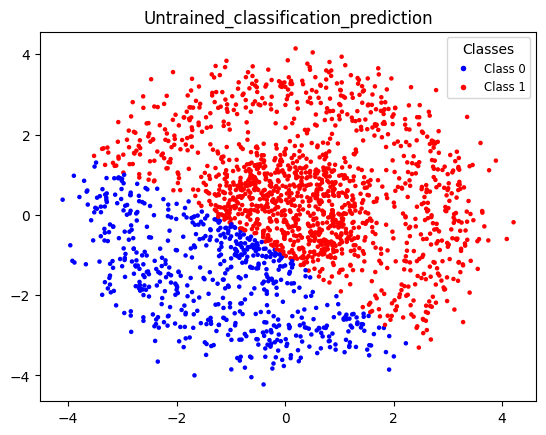

In [141]:
network = Sequential(Linear(2, 10), Tanh(), Linear(10, 5), ReLU(), Linear(5, 2), Softmax(), error_node=CrossEntropy())

# predictions = network(x[0:3])
# print(predictions)

predictions = network(x)
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(y, predicted_classes, target_names=['Class 0', 'Class 1'])
print('pre-training results:')
print(report)
create_plot_of_points(x, predicted_classes, 'Untrained_classification_prediction')
print('\n\n')

# print(network.layers[-1].output)
# network.backward(y[0:3])

# network.layers[-1].grad

In [142]:
lr = 0.1
epochs = 10

y_one_hot = np.eye(2)[y.astype(int)]

mini_batches = create_mini_batches(x, y_one_hot, 2)
# minibatch gradient-descent
for _ in range(epochs):
    for x_batch, y_batch in mini_batches:
        network(x_batch) # forward
        network.backward(y_batch)

        for layer_with_weights in network.weighted_layers: # iteramos los nodos/capas con pesos y los actualizamos
            layer_with_weights.w -= lr * layer_with_weights.grad[0]
            layer_with_weights.b -= lr * layer_with_weights.grad[1]
            

post-training results:
              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1000
     Class 1       0.98      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



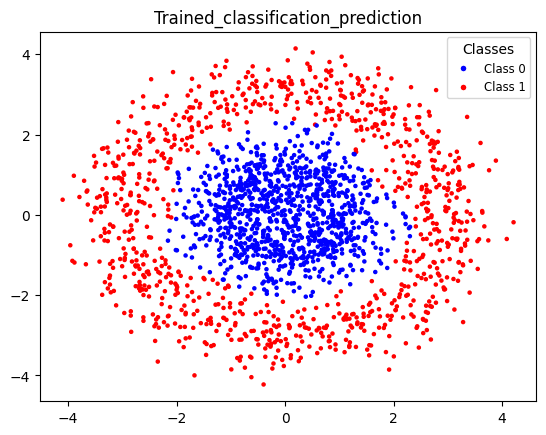

In [143]:
print('post-training results:')
predictions = network(x)        
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(y, predicted_classes, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)
create_plot_of_points(x, predicted_classes, 'Trained_classification_prediction')